In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List
import torchvision
import torch.utils.data as Data
import matplotlib.pyplot as plt

In [60]:
class residual(nn.Module):
    def __init__(self, input_channels, out_channels,
                 kernel_size, stride=1,
                 use_1x1_conv=False):
        super(residual, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels,
                              kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = None
        if use_1x1_conv:
            self.conv3 = nn.Conv2d(input_channels, out_channels,
                                   kernel_size=1, stride=stride)
    
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        
        y = self.bn2(self.conv2(y))
        
        if self.conv3:
            y += self.conv3(x)
        else: y += x
        
        return F.relu(y)

In [61]:
class res_block(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
            super(res_block, self).__init__()
            use_1x1_conv = (input_channels != output_channels)
            self.layer1 = residual(input_channels, output_channels,
                                   kernel_size=3, stride=stride,
                                   use_1x1_conv=use_1x1_conv)
            
            self.layer2 = residual(output_channels, output_channels,
                                   kernel_size=3)
            
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [62]:
class ResNet_18(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(ResNet_18, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        
        self.res_blk1 = res_block(8, 16, stride=2)
        self.res_blk2 = res_block(16, out_channels, stride=2)
        # self.res_blk3 = res_block(32, out_channels, stride=2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = self.res_blk1(x)
        x = self.res_blk2(x)
        # x = self.res_blk3(x)
        return x
        
        

In [63]:
class SE_block(nn.Module):
    def __init__(self, input_channels, reduce_ratio):
        super(SE_block, self).__init__()
        hidden_channels = input_channels // reduce_ratio
        
        self.fc1 = nn.Linear(input_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, input_channels)
        
    def forward(self, x):
        B, C, H, W = x.size()
        
        squeezed_tensor = x.view(B, C, -1).mean(dim=2)
        
        Y = F.relu(self.fc1(squeezed_tensor))
        Y = torch.sigmoid(self.fc2(Y))
        
        return torch.mul(x, Y.view(B, C, 1, 1))

In [64]:
model = nn.Sequential(ResNet_18(1, 32),
                      nn.AdaptiveAvgPool2d(32),
                      nn.Linear(32, 10))
for layer in model:
    print(layer)

ResNet_18(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_blk1): res_block(
    (layer1): residual(
      (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(8, 16, kernel_size=(1, 1), stride=(2, 2))
    )
    (layer2): residual(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_

In [65]:
# load MINIST dataset

train_data =  torchvision.datasets.MNIST(
    root = './MINIST/',
    train = True,
    transform = torchvision.transforms.ToTensor(),
    download = False
)

test_data = torchvision.datasets.MNIST(
    root = './MINIST/',
    train = False,
    download=False
)

tensor([2, 7, 4])


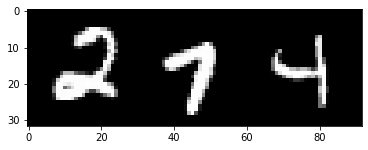

In [66]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=3, shuffle=True)


data_iter = iter(train_loader)
img, label = next(data_iter)
print(label)

img = torchvision.utils.make_grid(img)

plt.imshow(np.transpose(img.numpy(), (1,2,0)))

In [67]:
X = torch.rand((1,1,28,28))
for layer in model:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)
    # print(layer.__class__.__name__)

ResNet_18 output shape:	 torch.Size([1, 32, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 32, 32, 32])
Linear output shape:	 torch.Size([1, 32, 32, 10])


In [77]:
class AVNet(nn.Module):
    def __init__(self):
        super(AVNet, self).__init__()
        self.audio_net = ResNet_18(1, 32)
        self.visual_net = ResNet_18(1, 32)
        self.SE_layer = SE_block(64, 8)
        self.ada_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64, 10)
        
    def forward(self, a, v):
        a = self.audio_net(a)
        v = self.visual_net(v)
        
        x = self.SE_layer(torch.concat([a, v], dim=1))
        x = self.flatten(self.ada_pool(x))
        x = self.fc1(x)
        
        return x

In [78]:
x = torch.rand((1, 1, 28, 28))
y = torch.rand((1, 1, 28, 28))
model = AVNet()
res = model(x, y)
print(res.size())
    

torch.Size([1, 10])
